In [55]:
import pandas as pd
from sklearn.model_selection import KFold
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import warnings
from tqdm.auto import tqdm

In [56]:
df2 = pd.read_csv("../../data/processed/data_final.csv", encoding="utf-8", delimiter=",")

In [57]:
df = pd.read_csv("../../data/processed/dataset_variables_finales.csv", encoding="utf-8", delimiter=",")
df.head()

,precio,matrícula particular pagado 2024,superficie_total,simce 4to básico lectura 2022,banos,superficie_construida,longitud,latitud,distancia_metro,simce 4to básico matemáticas 2022,...,dormitorios,ingreso_promedio,pobreza por ingresos 2022 (%),matrícula subvencionada 2024,trabajadores_información_comunicaciones_2023,trabajadores_otras_actividades_2023,empresas_otras_actividades_2023,empresas_financieras_seguros_2023,indice_calidad_materiales,pobreza multidimensional 2022 (%)
0,322633576.0,6810.0,404.0,285.0,3.0,275.0,-70.678398,-33.345468,2554.229150,274.0,...,5.0,720051.66,4.3,4724.0,16518.0,3679.0,487.0,672.0,86.47,18.6
1,157180460.0,4221.0,190.0,279.0,2.0,127.0,-70.559425,-33.563025,2324.734493,268.0,...,3.0,538232.86,5.0,84429.0,658.0,2299.0,1922.0,723.0,93.75,18.9
2,133544301.0,3215.0,146.0,273.0,2.0,61.0,-70.689872,-33.641678,11151.846959,258.0,...,5.0,488733.18,6.0,38599.0,498.0,1233.0,843.0,262.0,89.94,18.7
3,117786861.0,769.0,145.0,273.0,2.0,82.0,-70.887450,-33.613778,16662.321199,256.0,...,3.0,591753.35,7.3,12798.0,93.0,118.0,299.0,61.0,84.18,15.1
4,153241100.0,2732.0,172.0,283.0,4.0,82.0,-70.709209,-33.360659,1948.472205,269.0,...,4.0,549642.87,5.2,33726.0,861.0,811.0,660.0,304.0,94.77,17.0


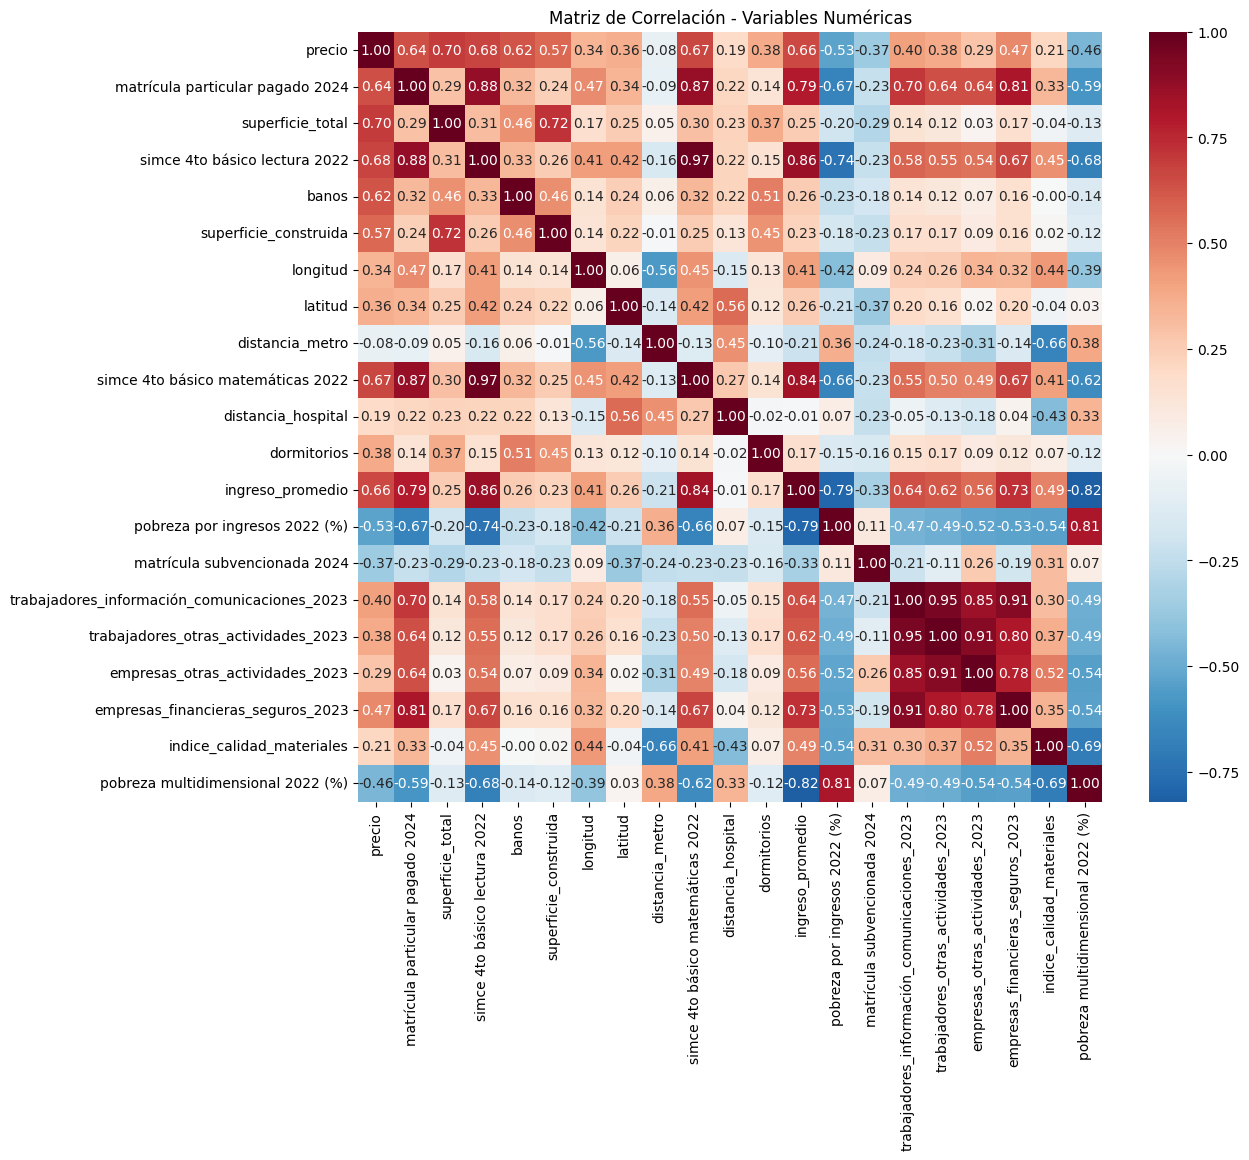

In [58]:
numeric_df = df.select_dtypes(include=[np.number])
correlation_matrix = numeric_df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, 
            annot=True, 
            cmap='RdBu_r', 
            center=0,
            fmt='.2f')
plt.title('Matriz de Correlación - Variables Numéricas')
plt.show()

In [59]:
variables_a_eliminar = [
    'empresas_otras_actividades_2023',
    'simce 4to básico lectura 2022',
    'matrícula particular pagado 2024',
    'simce 4to básico lectura 2022',
    'trabajadores_información_comunicaciones_2023',
    'simce 4to básico matemáticas 2022',
    'pobreza por ingresos 2022 (%)',
    'pobreza multidimensional 2022 (%)'
]

df = df.drop(variables_a_eliminar, axis=1)
df.columns

Index(['precio', 'superficie_total', 'banos', 'superficie_construida',
       'longitud', 'latitud', 'distancia_metro', 'distancia_hospital',
       'dormitorios', 'ingreso_promedio', 'matrícula subvencionada 2024',
       'trabajadores_otras_actividades_2023',
       'empresas_financieras_seguros_2023', 'indice_calidad_materiales'],
      dtype='object')

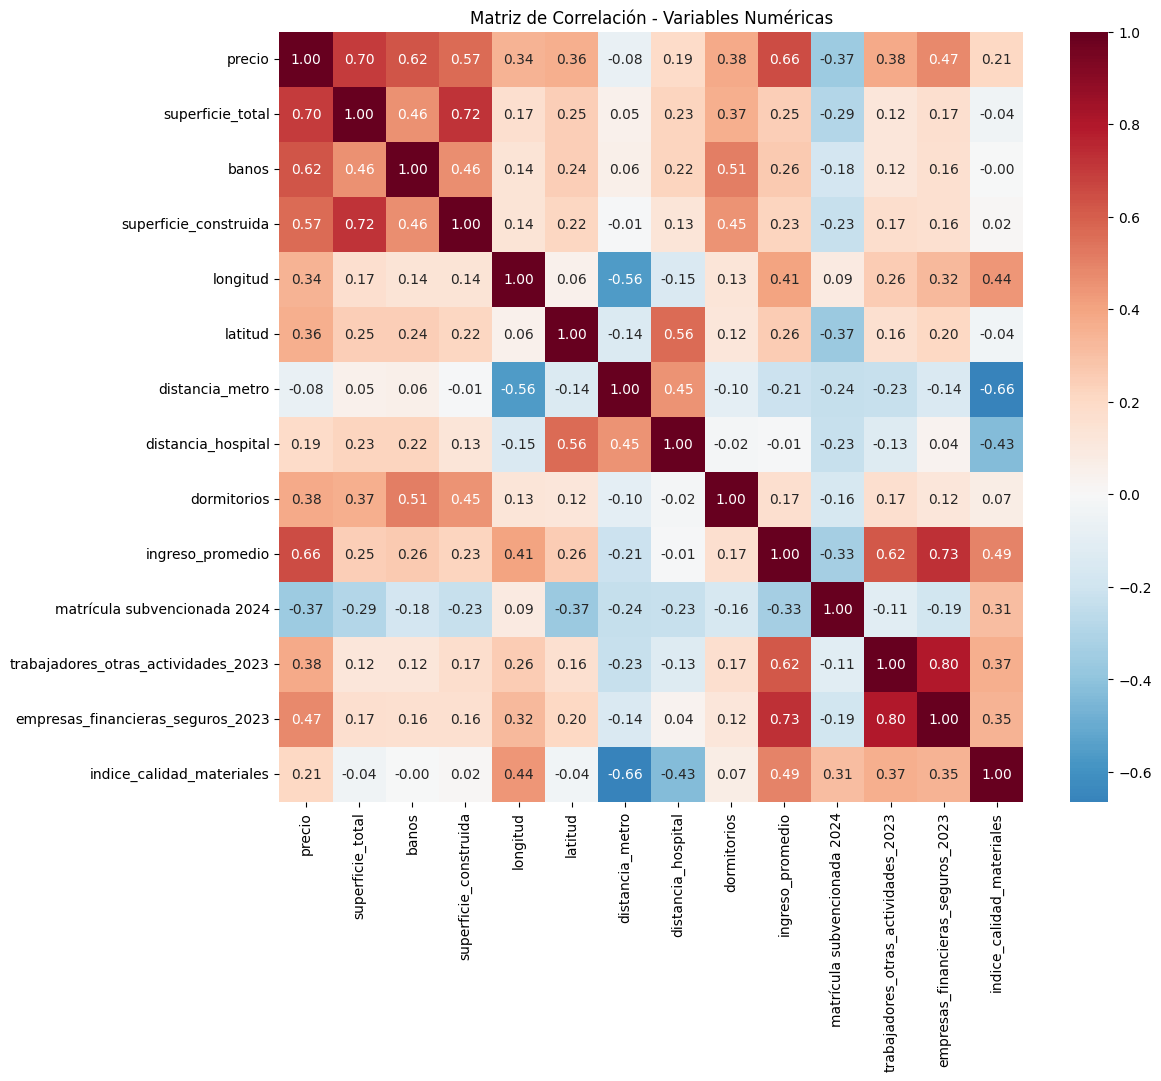

In [60]:
numeric_df = df.select_dtypes(include=[np.number])
correlation_matrix = numeric_df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, 
            annot=True, 
            cmap='RdBu_r', 
            center=0,
            fmt='.2f')
plt.title('Matriz de Correlación - Variables Numéricas')
plt.show()

In [61]:
df.columns

Index(['precio', 'superficie_total', 'banos', 'superficie_construida',
       'longitud', 'latitud', 'distancia_metro', 'distancia_hospital',
       'dormitorios', 'ingreso_promedio', 'matrícula subvencionada 2024',
       'trabajadores_otras_actividades_2023',
       'empresas_financieras_seguros_2023', 'indice_calidad_materiales'],
      dtype='object')

In [62]:
class MLPPipeline:
    def __init__(self, X, y, test_size=0.2, random_state=42):
        """Pipeline completo para entrenar MLP"""
        self.X = X
        self.y = y
        self.test_size = test_size
        self.random_state = random_state
        
        self.model = None
        self.scaler_X = StandardScaler()
        self.scaler_y = StandardScaler()
        self.train_losses = []
        self.val_losses = []
        
    def prepare_data(self):
        """Split y normalización"""
        y_binned = pd.qcut(self.y, q=10, duplicates='drop')
        X_train, X_test, y_train, y_test = train_test_split(
            self.X, self.y, test_size=self.test_size, 
            random_state=self.random_state, stratify=y_binned
        )
        
        X_train_scaled = self.scaler_X.fit_transform(X_train)
        X_test_scaled = self.scaler_X.transform(X_test)
        
        y_train_scaled = self.scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
        y_test_scaled = self.scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()
        
        self.X_train = torch.FloatTensor(X_train_scaled)
        self.X_test = torch.FloatTensor(X_test_scaled)
        self.y_train = torch.FloatTensor(y_train_scaled)
        self.y_test = torch.FloatTensor(y_test_scaled)
        
        self.y_train_orig = y_train
        self.y_test_orig = y_test
        
        print(f"Train: {self.X_train.shape}, Test: {self.X_test.shape}")
        
    def build_model(self, architecture='default'):
        """Construir modelo"""
        n_features = self.X_train.shape[1]
        
        if architecture == 'default':
            layers = [128, 64, 32]
            dropouts = [0.3, 0.2, 0.1]
        elif architecture == 'deep':
            layers = [256, 128, 64, 32]
            dropouts = [0.4, 0.3, 0.2, 0.1]
        elif architecture == 'wide':
            layers = [256, 128]
            dropouts = [0.3, 0.2]
        elif isinstance(architecture, list):
            layers = architecture
            dropouts = [0.3] * len(layers)
        
        modules = []
        in_features = n_features
        
        for out_features, dropout in zip(layers, dropouts):
            modules.extend([
                nn.Linear(in_features, out_features),
                nn.BatchNorm1d(out_features),
                nn.ReLU(),
                nn.Dropout(dropout)
            ])
            in_features = out_features
        
        modules.append(nn.Linear(in_features, 1))
        self.model = nn.Sequential(*modules)
        
        n_params = sum(p.numel() for p in self.model.parameters())
        print(f"Modelo: {n_features} features → {layers} → 1 ({n_params:,} parámetros)")
        
    def train(self, epochs=100, batch_size=32, lr=0.001, weight_decay=1e-4):
        """Entrenar modelo"""
        criterion = nn.MSELoss()
        optimizer = optim.Adam(self.model.parameters(), lr=lr, weight_decay=weight_decay)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=10
        )
        
        train_dataset = TensorDataset(self.X_train, self.y_train)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        
        print(f"\nEntrenando {epochs} épocas...")
        
        for epoch in range(epochs):
            self.model.train()
            train_loss = 0.0
            
            for batch_x, batch_y in train_loader:
                optimizer.zero_grad()
                outputs = self.model(batch_x).squeeze()
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
            
            self.model.eval()
            with torch.no_grad():
                val_outputs = self.model(self.X_test).squeeze()
                val_loss = criterion(val_outputs, self.y_test).item()
            
            self.train_losses.append(train_loss / len(train_loader))
            self.val_losses.append(val_loss)
            
            scheduler.step(val_loss)
            
            if (epoch + 1) % 20 == 0:
                print(f'Época {epoch+1}/{epochs} - Train: {self.train_losses[-1]:.4f}, Val: {val_loss:.4f}')
        
        print("✓ Entrenamiento completado")
        
    def evaluate(self):
        """Evaluar modelo"""
        self.model.eval()
        with torch.no_grad():
            train_pred_scaled = self.model(self.X_train).squeeze().numpy()
            test_pred_scaled = self.model(self.X_test).squeeze().numpy()
        
        train_pred = self.scaler_y.inverse_transform(train_pred_scaled.reshape(-1, 1)).flatten()
        test_pred = self.scaler_y.inverse_transform(test_pred_scaled.reshape(-1, 1)).flatten()
        
        results = {
            'train': self._calculate_metrics(self.y_train_orig, train_pred),
            'test': self._calculate_metrics(self.y_test_orig, test_pred)
        }
        
        self._print_results(results)
        return results
    
    def _calculate_metrics(self, y_true, y_pred):
        """Calcular métricas"""
        mse = mean_squared_error(y_true, y_pred)
        mae = mean_absolute_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)
        
        mask = y_true != 0
        mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
        mae_pct = (mae / np.mean(y_true)) * 100
        
        return {
            'rmse': np.sqrt(mse),
            'mae': mae,
            'mape': mape,
            'mae_pct': mae_pct,
            'r2': r2
        }
    
    def _print_results(self, results):
        """Imprimir resultados"""
        print("\n" + "="*50)
        print("RESULTADOS DEL MODELO")
        print("="*50)
        
        for split in ['train', 'test']:
            metrics = results[split]
            print(f"\n{split.upper()}:")
            print(f"  RMSE:        ${metrics['rmse']:,.0f}")
            print(f"  MAE:         ${metrics['mae']:,.0f}")
            print(f"  MAPE:        {metrics['mape']:.2f}%")
            print(f"  MAE %:       {metrics['mae_pct']:.2f}%")
            print(f"  R²:          {metrics['r2']:.4f}")

print(f"✓ Pipeline listo - PyTorch {torch.__version__}")

✓ Pipeline listo - PyTorch 2.5.1+cu121


In [63]:
# ============================================================
# CELDA 3: Experimento 1 - 20 variables
# ============================================================
X_20 = df.drop(columns=['precio'])
y_20 = df['precio']

pipeline_20 = MLPPipeline(X_20, y_20)
pipeline_20.prepare_data()
pipeline_20.build_model(architecture='default')  # 128-64-32
pipeline_20.train(epochs=100, batch_size=32, lr=0.001)
results_20 = pipeline_20.evaluate()

Train: torch.Size([3620, 13]), Test: torch.Size([905, 13])
Modelo: 13 features → [128, 64, 32] → 1 (12,609 parámetros)

Entrenando 100 épocas...
Época 20/100 - Train: 0.2081, Val: 0.1697
Época 40/100 - Train: 0.1977, Val: 0.1746
Época 60/100 - Train: 0.1788, Val: 0.1577
Época 80/100 - Train: 0.1756, Val: 0.1555
Época 100/100 - Train: 0.1728, Val: 0.1524
✓ Entrenamiento completado

RESULTADOS DEL MODELO

TRAIN:
  RMSE:        $56,802,026
  MAE:         $38,297,162
  MAPE:        20.46%
  MAE %:       16.90%
  R²:          0.8866

TEST:
  RMSE:        $65,844,510
  MAE:         $42,322,007
  MAPE:        22.58%
  MAE %:       18.60%
  R²:          0.8533


In [64]:
# ============================================================
# CELDA 4: Experimento 2 - 160 variables
# ============================================================
X_160 = df2.drop(columns=['precio'])
X_160_encoded = pd.get_dummies(X_160, columns=['comuna'], drop_first=True)

print(f"Variables después de encoding: {X_160_encoded.shape[1]}")

y_160 = df2['precio']

X_160_clean = X_160_encoded.dropna()
y_160_clean = y_160.loc[X_160_clean.index]

print(f"Filas antes: {X_160_encoded.shape[0]}, después: {X_160_clean.shape[0]}")
print(f"Filas eliminadas: {X_160_encoded.shape[0] - X_160_clean.shape[0]}")

pipeline_160 = MLPPipeline(X_160_clean, y_160_clean)  # ✅ CAMBIO AQUÍ
pipeline_160.prepare_data()
pipeline_160.build_model(architecture='deep')

pipeline_160.train(
    epochs=150, 
    batch_size=64,
    lr=0.0001,
    weight_decay=1e-3
)

results_160 = pipeline_160.evaluate()

Variables después de encoding: 210
Filas antes: 4525, después: 4508
Filas eliminadas: 17
Train: torch.Size([3606, 210]), Test: torch.Size([902, 210])
Modelo: 210 features → [256, 128, 64, 32] → 1 (98,241 parámetros)

Entrenando 150 épocas...
Época 20/150 - Train: 0.2573, Val: 0.1919
Época 40/150 - Train: 0.2388, Val: 0.1692
Época 60/150 - Train: 0.2015, Val: 0.1605
Época 80/150 - Train: 0.1988, Val: 0.1588
Época 100/150 - Train: 0.1997, Val: 0.1564
Época 120/150 - Train: 0.1857, Val: 0.1536
Época 140/150 - Train: 0.2033, Val: 0.1543
✓ Entrenamiento completado

RESULTADOS DEL MODELO

TRAIN:
  RMSE:        $64,256,942
  MAE:         $42,054,364
  MAPE:        21.04%
  MAE %:       18.51%
  R²:          0.8569

TEST:
  RMSE:        $67,892,325
  MAE:         $44,085,694
  MAPE:        22.92%
  MAE %:       19.51%
  R²:          0.8366


In [65]:
# ============================================================
# CELDA 5: Comparación final
# ============================================================
print("\n" + "="*70)
print("📊 COMPARACIÓN: 20 VARIABLES vs 160 VARIABLES")
print("="*70)

comparison = pd.DataFrame({
    '20 vars': results_20['test'],
    '160 vars': results_160['test']
}).T

print(comparison)

# Determinar ganador
if results_20['test']['r2'] > results_160['test']['r2']:
    print(f"\n🏆 GANADOR: 20 variables (R² {results_20['test']['r2']:.4f} vs {results_160['test']['r2']:.4f})")
else:
    print(f"\n🏆 GANADOR: 160 variables (R² {results_160['test']['r2']:.4f} vs {results_20['test']['r2']:.4f})")


📊 COMPARACIÓN: 20 VARIABLES vs 160 VARIABLES
                  rmse           mae       mape    mae_pct        r2
20 vars   6.584451e+07  4.232201e+07  22.581450  18.596407  0.853255
160 vars  6.789232e+07  4.408569e+07  22.922651  19.507096  0.836574

🏆 GANADOR: 20 variables (R² 0.8533 vs 0.8366)


In [66]:
y = df['precio']

X = df.drop(columns=['precio'])

y_binned = pd.qcut(y, q=10, duplicates='drop')
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y_binned
)

print(f"Tamaño conjunto entrenamiento: {X_train.shape}")
print(f"Tamaño conjunto prueba: {X_test.shape}")

Tamaño conjunto entrenamiento: (3620, 13)
Tamaño conjunto prueba: (905, 13)


In [67]:
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

print("Datos normalizados:")
print(f"X_train shape: {X_train_scaled.shape}")
print(f"X_test shape: {X_test_scaled.shape}")
print(f"y_train range: [{y_train_scaled.min():.3f}, {y_train_scaled.max():.3f}]")
print(f"y_test range: [{y_test_scaled.min():.3f}, {y_test_scaled.max():.3f}]")

Datos normalizados:
X_train shape: (3620, 13)
X_test shape: (905, 13)
y_train range: [-1.136, 3.989]
y_test range: [-1.118, 3.985]


In [68]:
X_train_tensor = torch.FloatTensor(X_train_scaled)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_train_tensor = torch.FloatTensor(y_train_scaled)
y_test_tensor = torch.FloatTensor(y_test_scaled)

print("Tensores creados:")
print(f"X_train_tensor shape: {X_train_tensor.shape}")
print(f"X_test_tensor shape: {X_test_tensor.shape}")
print(f"y_train_tensor shape: {y_train_tensor.shape}")
print(f"y_test_tensor shape: {y_test_tensor.shape}")

Tensores creados:
X_train_tensor shape: torch.Size([3620, 13])
X_test_tensor shape: torch.Size([905, 13])
y_train_tensor shape: torch.Size([3620])
y_test_tensor shape: torch.Size([905])


In [69]:
class HousePriceNN(nn.Module):
    def __init__(self, n_features):
        super(HousePriceNN, self).__init__()
        
        # Red neuronal principal
        self.network = nn.Sequential(
            # Primera capa oculta
            nn.Linear(n_features, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            # Segunda capa oculta
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            # Tercera capa oculta
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            # Capa de salida
            nn.Linear(32, 1)
        )
    
    def forward(self, x):
        return self.network(x)

# Crear el modelo
n_features = X_train_tensor.shape[1]
model = HousePriceNN(n_features)

print(f"Modelo creado:")
print(f"- Número de características: {n_features}")
print(f"- Número total de parámetros: {sum(p.numel() for p in model.parameters())}")
print("\nArquitectura del modelo:")
print(model)

Modelo creado:
- Número de características: 13
- Número total de parámetros: 12609

Arquitectura del modelo:
HousePriceNN(
  (network): Sequential(
    (0): Linear(in_features=13, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=64, out_features=32, bias=True)
    (9): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.1, inplace=False)
    (12): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [70]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor) 
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

print("Configuración del entrenamiento:")
print(f"Función de pérdida: {criterion}")
print(f"Optimizador: Adam con lr=0.001")
print(f"Batch size: {batch_size}")
print(f"Número de batches por época: {len(train_loader)}")

Configuración del entrenamiento:
Función de pérdida: MSELoss()
Optimizador: Adam con lr=0.001
Batch size: 32
Número de batches por época: 114


In [71]:
def train_model(model, train_loader, criterion, optimizer, scheduler,
                X_test, y_test, num_epochs=100):
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        # Entrenamiento
        model.train()
        train_loss = 0.0
        
        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_x).squeeze()
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        # Validación
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_test).squeeze()
            val_loss = criterion(val_outputs, y_test).item()
        
        # Guardar pérdidas
        train_losses.append(train_loss / len(train_loader))
        val_losses.append(val_loss)
        
        # Actualizar learning rate
        scheduler.step(val_loss)
        
        # Imprimir progreso cada 10 épocas
        if (epoch + 1) % 10 == 0:
            print(f'Época [{epoch+1}/{num_epochs}], '
                  f'Train Loss: {train_losses[-1]:.4f}, '
                  f'Val Loss: {val_losses[-1]:.4f}')
    
    return train_losses, val_losses

print("Función de entrenamiento definida")

Función de entrenamiento definida


In [72]:
print("Iniciando entrenamiento...")
train_losses, val_losses = train_model(
    model, train_loader, criterion, optimizer, scheduler,
    X_test_tensor, y_test_tensor, num_epochs=100
)

print("\n¡Entrenamiento completado!")

Iniciando entrenamiento...
Época [10/100], Train Loss: 0.2404, Val Loss: 0.1720
Época [20/100], Train Loss: 0.2119, Val Loss: 0.1589
Época [30/100], Train Loss: 0.2022, Val Loss: 0.1564
Época [40/100], Train Loss: 0.1955, Val Loss: 0.1613
Época [50/100], Train Loss: 0.1820, Val Loss: 0.1504
Época [60/100], Train Loss: 0.1936, Val Loss: 0.1548
Época [70/100], Train Loss: 0.1868, Val Loss: 0.1544
Época [80/100], Train Loss: 0.1821, Val Loss: 0.1537
Época [90/100], Train Loss: 0.1688, Val Loss: 0.1572
Época [100/100], Train Loss: 0.1703, Val Loss: 0.1520

¡Entrenamiento completado!


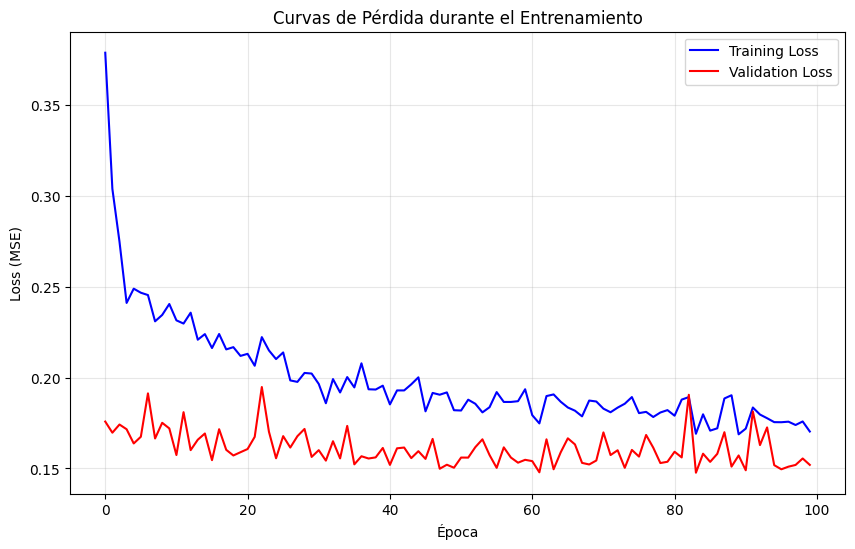

Pérdida final de entrenamiento: 0.1703
Pérdida final de validación: 0.1520


In [73]:
# Visualizar las curvas de pérdida
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='red')
plt.title('Curvas de Pérdida durante el Entrenamiento')
plt.xlabel('Época')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Pérdida final de entrenamiento: {train_losses[-1]:.4f}")
print(f"Pérdida final de validación: {val_losses[-1]:.4f}")

In [74]:
model.eval()
with torch.no_grad():
    # Predicciones en escala normalizada
    train_pred_scaled = model(X_train_tensor).squeeze().numpy()
    test_pred_scaled = model(X_test_tensor).squeeze().numpy()
    
    # Desnormalizar las predicciones para obtener valores reales
    train_pred = scaler_y.inverse_transform(train_pred_scaled.reshape(-1, 1)).flatten()
    test_pred = scaler_y.inverse_transform(test_pred_scaled.reshape(-1, 1)).flatten()

# Función para calcular MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

# Función para calcular MAE porcentual
def mae_percentage(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mean_true = np.mean(y_true)
    return (mae / mean_true) * 100

# Métricas en conjunto de entrenamiento
train_mse = mean_squared_error(y_train, train_pred)
train_mae = mean_absolute_error(y_train, train_pred)
train_mape = mean_absolute_percentage_error(y_train, train_pred)
train_mae_pct = mae_percentage(y_train, train_pred)
train_r2 = r2_score(y_train, train_pred)

# Métricas en conjunto de prueba
test_mse = mean_squared_error(y_test, test_pred)
test_mae = mean_absolute_error(y_test, test_pred)
test_mape = mean_absolute_percentage_error(y_test, test_pred)
test_mae_pct = mae_percentage(y_test, test_pred)
test_r2 = r2_score(y_test, test_pred)

print("=== MÉTRICAS DE EVALUACIÓN MLP ===")
print("\nConjunto de Entrenamiento:")
print(f"RMSE: ${np.sqrt(train_mse):,.0f}")
print(f"MAE: ${train_mae:,.0f}")
print(f"MAPE: {train_mape:.2f}%")
print(f"MAE Porcentual: {train_mae_pct:.2f}%")
print(f"R² Score: {train_r2:.4f}")

print("\nConjunto de Prueba:")
print(f"RMSE: ${np.sqrt(test_mse):,.0f}")
print(f"MAE: ${test_mae:,.0f}")
print(f"MAPE: {test_mape:.2f}%")
print(f"MAE Porcentual: {test_mae_pct:.2f}%")
print(f"R² Score: {test_r2:.4f}")

=== MÉTRICAS DE EVALUACIÓN MLP ===

Conjunto de Entrenamiento:
RMSE: $57,239,341
MAE: $38,908,087
MAPE: 21.59%
MAE Porcentual: 17.17%
R² Score: 0.8848

Conjunto de Prueba:
RMSE: $65,751,533
MAE: $42,896,591
MAPE: 23.93%
MAE Porcentual: 18.85%
R² Score: 0.8537


precio                                 1.000000
superficie_total                       0.695917
ingreso_promedio                       0.655023
banos                                  0.623860
superficie_construida                  0.567536
empresas_financieras_seguros_2023      0.474411
dormitorios                            0.380177
trabajadores_otras_actividades_2023    0.376252
latitud                                0.363917
longitud                               0.343379
indice_calidad_materiales              0.212285
distancia_hospital                     0.192036
distancia_metro                       -0.077023
matrícula subvencionada 2024          -0.365043
Name: precio, dtype: float64
Variables con fecha 2024-2025:
['matrícula subvencionada 2024']


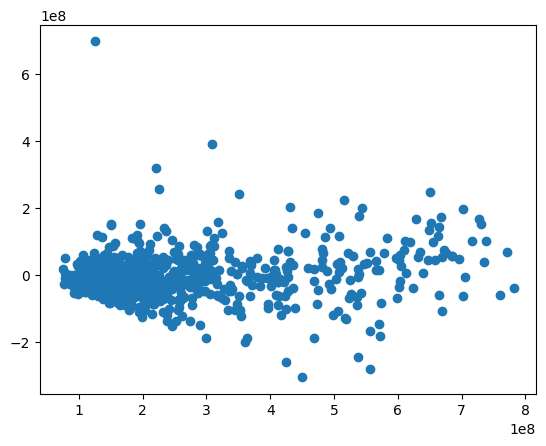

In [75]:
print(df.corr()['precio'].sort_values(ascending=False))

print("Variables con fecha 2024-2025:")
print([col for col in df.columns if '2024' in col or '2025' in col])

residuales = y_test - test_pred
plt.scatter(test_pred, residuales)

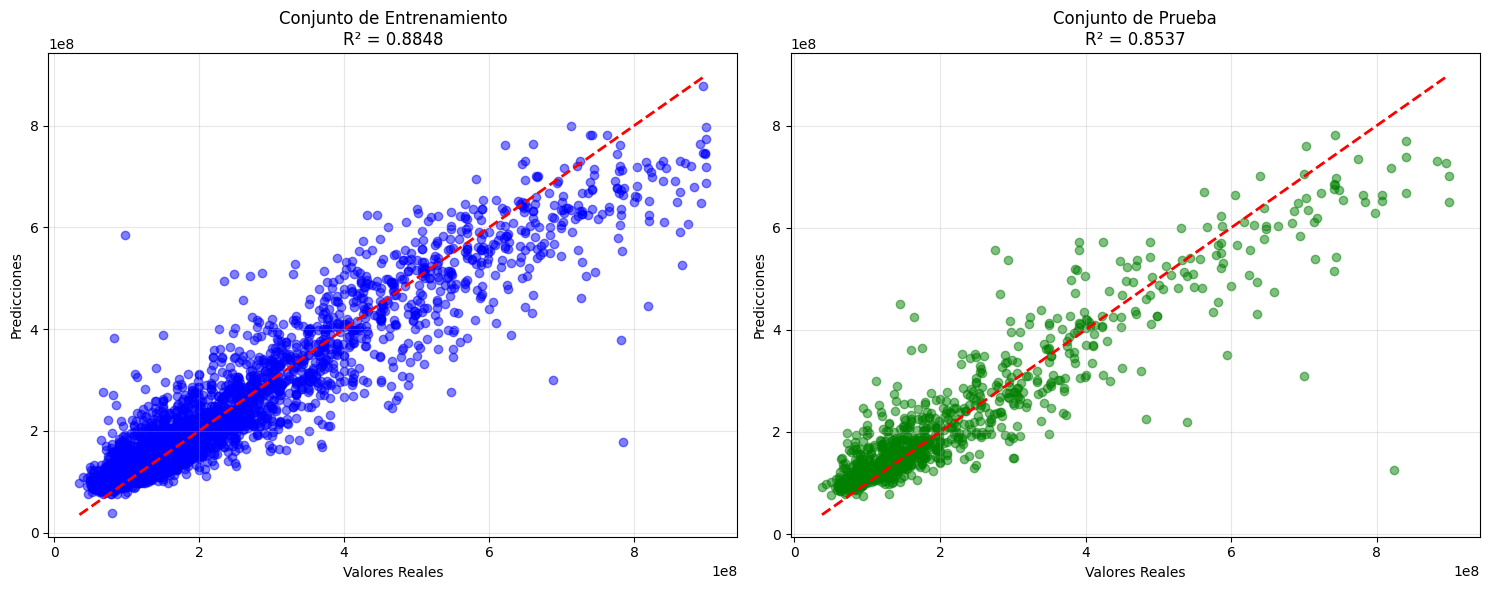

In [76]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.scatter(y_train, train_pred, alpha=0.5, color='blue')
ax1.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
ax1.set_xlabel('Valores Reales')
ax1.set_ylabel('Predicciones')
ax1.set_title(f'Conjunto de Entrenamiento\nR² = {train_r2:.4f}')
ax1.grid(True, alpha=0.3)

ax2.scatter(y_test, test_pred, alpha=0.5, color='green')
ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
ax2.set_xlabel('Valores Reales')
ax2.set_ylabel('Predicciones')
ax2.set_title(f'Conjunto de Prueba\nR² = {test_r2:.4f}')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [77]:
def train_model_single_fold(model, train_loader, criterion, optimizer, scheduler,
                           X_val, y_val, num_epochs=100):
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        
        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_x).squeeze()
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val).squeeze()
            val_loss = criterion(val_outputs, y_val).item()

        train_losses.append(train_loss / len(train_loader))
        val_losses.append(val_loss)
        scheduler.step(val_loss)
    
    return train_losses, val_losses

def kfold_cross_validation(X_data, y_data, n_splits=5, num_epochs=100, batch_size=32):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    fold_train_losses = []
    fold_val_losses = []
    fold_metrics = []
    
    print(f"Iniciando {n_splits}-Fold Cross Validation...")
    print("="*60)
    
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X_data)):
        print(f"\nFOLD {fold + 1}/{n_splits}")
        print("-" * 30)
        
        X_train_fold = X_data[train_idx]
        X_val_fold = X_data[val_idx]
        y_train_fold = y_data[train_idx]
        y_val_fold = y_data[val_idx]
        
        scaler_X_fold = StandardScaler()
        scaler_y_fold = StandardScaler()
        
        X_train_fold_scaled = scaler_X_fold.fit_transform(X_train_fold)
        X_val_fold_scaled = scaler_X_fold.transform(X_val_fold)
        
        y_train_fold_scaled = scaler_y_fold.fit_transform(y_train_fold.reshape(-1, 1)).flatten()
        y_val_fold_scaled = scaler_y_fold.transform(y_val_fold.reshape(-1, 1)).flatten()
        
        X_train_fold_tensor = torch.FloatTensor(X_train_fold_scaled)
        X_val_fold_tensor = torch.FloatTensor(X_val_fold_scaled)
        y_train_fold_tensor = torch.FloatTensor(y_train_fold_scaled)
        y_val_fold_tensor = torch.FloatTensor(y_val_fold_scaled)
        
        train_dataset_fold = TensorDataset(X_train_fold_tensor, y_train_fold_tensor)
        train_loader_fold = DataLoader(train_dataset_fold, batch_size=batch_size, shuffle=True)
        
        model_fold = HousePriceNN(X_train_fold_tensor.shape[1])
        criterion_fold = nn.MSELoss()
        optimizer_fold = optim.Adam(model_fold.parameters(), lr=0.001, weight_decay=1e-4)
        scheduler_fold = optim.lr_scheduler.ReduceLROnPlateau(optimizer_fold, mode='min', factor=0.5, patience=10)
        
        train_losses, val_losses = train_model_single_fold(
            model_fold, train_loader_fold, criterion_fold, optimizer_fold, scheduler_fold,
            X_val_fold_tensor, y_val_fold_tensor, num_epochs=num_epochs
        )
        
        model_fold.eval()
        with torch.no_grad():
            val_pred_scaled = model_fold(X_val_fold_tensor).squeeze().numpy()
            val_pred = scaler_y_fold.inverse_transform(val_pred_scaled.reshape(-1, 1)).flatten()
        
        fold_mse = mean_squared_error(y_val_fold, val_pred)
        fold_mae = mean_absolute_error(y_val_fold, val_pred)
        fold_r2 = r2_score(y_val_fold, val_pred)
        fold_rmse = np.sqrt(fold_mse)
        
        fold_train_losses.append(train_losses)
        fold_val_losses.append(val_losses)
        fold_metrics.append({
            'fold': fold + 1,
            'mse': fold_mse,
            'mae': fold_mae,
            'rmse': fold_rmse,
            'r2': fold_r2,
            'final_train_loss': train_losses[-1],
            'final_val_loss': val_losses[-1]
        })
        
        print(f"Fold {fold + 1} - RMSE: ${fold_rmse:,.0f}, MAE: ${fold_mae:,.0f}, R²: {fold_r2:.4f}")
    
    avg_mse = np.mean([m['mse'] for m in fold_metrics])
    avg_mae = np.mean([m['mae'] for m in fold_metrics])
    avg_rmse = np.mean([m['rmse'] for m in fold_metrics])
    avg_r2 = np.mean([m['r2'] for m in fold_metrics])
    
    std_mse = np.std([m['mse'] for m in fold_metrics])
    std_mae = np.std([m['mae'] for m in fold_metrics])
    std_rmse = np.std([m['rmse'] for m in fold_metrics])
    std_r2 = np.std([m['r2'] for m in fold_metrics])
    
    print("\n" + "="*60)
    print("RESULTADOS FINALES K-FOLD CROSS VALIDATION")
    print("="*60)
    print(f"RMSE: ${avg_rmse:,.0f} (±${std_rmse:,.0f})")
    print(f"MAE: ${avg_mae:,.0f} (±${std_mae:,.0f})")
    print(f"R² Score: {avg_r2:.4f} (±{std_r2:.4f})")
    
    return fold_metrics, fold_train_losses, fold_val_losses

print("Preparando datos para K-Fold Cross Validation...")

X_full = X.values
y_full = y.values  

cv_results, cv_train_losses, cv_val_losses = kfold_cross_validation(
    X_full, y_full, 
    n_splits=5, 
    num_epochs=100, 
    batch_size=32
)

Preparando datos para K-Fold Cross Validation...
Iniciando 5-Fold Cross Validation...

FOLD 1/5
------------------------------


KeyboardInterrupt: 

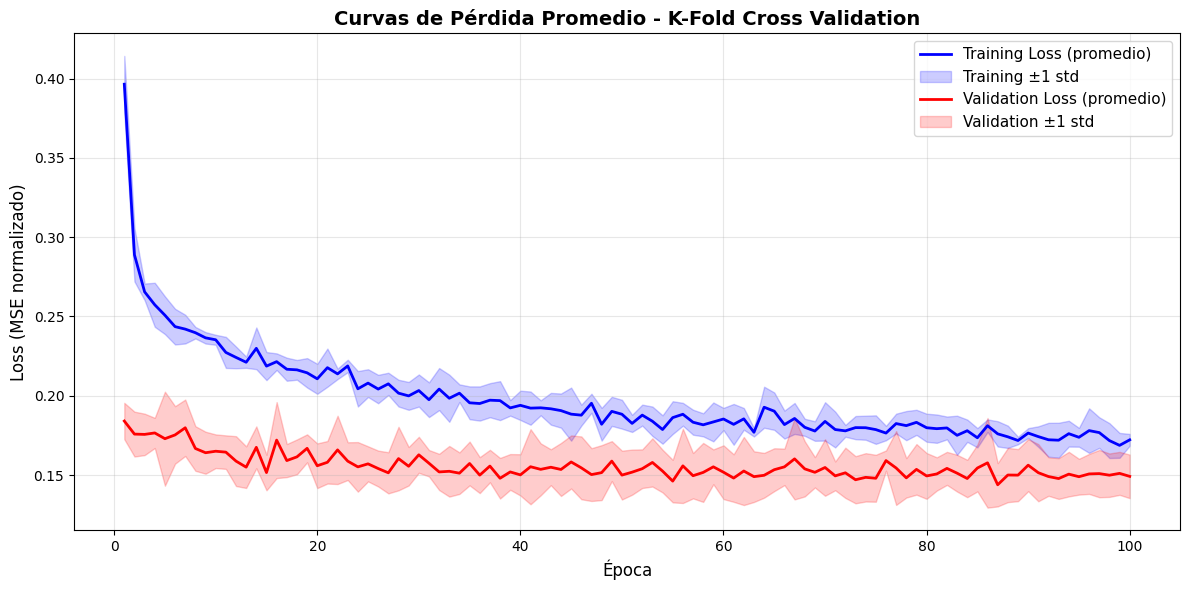

Pérdida final promedio - Training: 0.1722 (±0.0037)
Pérdida final promedio - Validation: 0.1492 (±0.0137)


In [ ]:
plt.figure(figsize=(12, 6))

max_epochs = min(len(losses) for losses in cv_train_losses)
epochs = range(1, max_epochs + 1)

avg_train_losses = []
std_train_losses = []
avg_val_losses = []
std_val_losses = []

for epoch in range(max_epochs):
    train_epoch_losses = [losses[epoch] for losses in cv_train_losses if epoch < len(losses)]
    val_epoch_losses = [losses[epoch] for losses in cv_val_losses if epoch < len(losses)]
    
    avg_train_losses.append(np.mean(train_epoch_losses))
    std_train_losses.append(np.std(train_epoch_losses))
    avg_val_losses.append(np.mean(val_epoch_losses))
    std_val_losses.append(np.std(val_epoch_losses))

avg_train_losses = np.array(avg_train_losses)
std_train_losses = np.array(std_train_losses)
avg_val_losses = np.array(avg_val_losses)
std_val_losses = np.array(std_val_losses)

plt.plot(epochs, avg_train_losses, 'b-', label='Training Loss (promedio)', linewidth=2)
plt.fill_between(epochs, avg_train_losses - std_train_losses, avg_train_losses + std_train_losses, 
                 alpha=0.2, color='blue', label='Training ±1 std')
plt.plot(epochs, avg_val_losses, 'r-', label='Validation Loss (promedio)', linewidth=2)
plt.fill_between(epochs, avg_val_losses - std_val_losses, avg_val_losses + std_val_losses, 
                 alpha=0.2, color='red', label='Validation ±1 std')

plt.title('Curvas de Pérdida Promedio - K-Fold Cross Validation', fontsize=14, fontweight='bold')
plt.xlabel('Época', fontsize=12)
plt.ylabel('Loss (MSE normalizado)', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Pérdida final promedio - Training: {avg_train_losses[-1]:.4f} (±{std_train_losses[-1]:.4f})")
print(f"Pérdida final promedio - Validation: {avg_val_losses[-1]:.4f} (±{std_val_losses[-1]:.4f})")

In [ ]:
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances
from sklearn.metrics import r2_score, mean_squared_error

def objective(trial):
    """
    Función objetivo para Optuna que define el espacio de búsqueda
    y entrena el modelo con cada configuración
    """
    
    # 1. HIPERPARÁMETROS DE ARQUITECTURA
    n_layers = trial.suggest_int('n_layers', 2, 4)
    
    layer_sizes = []
    prev_size = X_train_tensor.shape[1]
    
    for i in range(n_layers):
        if i == 0:
            size = trial.suggest_int(f'layer_{i}_size', 32, 256, step=32)
        else:
            max_size = max(prev_size // 2, 16)
            min_size = 16
            
            if max_size < min_size:
                size = trial.suggest_int(f'layer_{i}_size', 16, 32, step=16)
            else:
                size = trial.suggest_int(f'layer_{i}_size', min_size, max_size, step=16)
        
        layer_sizes.append(size)
        prev_size = size
    
    dropout_rates = [
        trial.suggest_float(f'dropout_{i}', 0.0, 0.5, step=0.1)
        for i in range(n_layers)
    ]
    
    use_batch_norm = trial.suggest_categorical('use_batch_norm', [True, False])
    
    # 2. HIPERPARÁMETROS DE ENTRENAMIENTO
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-3, log=True)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128])
    
    # 3. SCHEDULER
    scheduler_patience = trial.suggest_int('scheduler_patience', 5, 20)
    scheduler_factor = trial.suggest_float('scheduler_factor', 0.3, 0.7, step=0.1)
    
    # 4. CONSTRUIR MODELO DINÁMICAMENTE
    class DynamicHousePriceNN(nn.Module):
        def __init__(self, n_features, layer_sizes, dropout_rates, use_batch_norm):
            super(DynamicHousePriceNN, self).__init__()
            
            layers = []
            input_size = n_features
            
            for i, (hidden_size, dropout) in enumerate(zip(layer_sizes, dropout_rates)):
                layers.append(nn.Linear(input_size, hidden_size))
                
                if use_batch_norm:
                    layers.append(nn.BatchNorm1d(hidden_size))
                
                layers.append(nn.ReLU())
                
                if dropout > 0:
                    layers.append(nn.Dropout(dropout))
                
                input_size = hidden_size
            
            layers.append(nn.Linear(input_size, 1))
            
            self.network = nn.Sequential(*layers)
        
        def forward(self, x):
            return self.network(x)
    
    # 5. CREAR MODELO, OPTIMIZADOR Y SCHEDULER
    model = DynamicHousePriceNN(
        X_train_tensor.shape[1], 
        layer_sizes, 
        dropout_rates, 
        use_batch_norm
    )
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(
        model.parameters(), 
        lr=learning_rate, 
        weight_decay=weight_decay
    )
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='min', 
        factor=scheduler_factor, 
        patience=scheduler_patience
    )
    
    # 6. DATALOADER
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    # 7. ENTRENAMIENTO (con early stopping)
    num_epochs = 100
    best_val_loss = float('inf')
    patience_counter = 0
    early_stop_patience = 15
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        
        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_x).squeeze()
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_test_tensor).squeeze()
            val_loss = criterion(val_outputs, y_test_tensor).item()
        
        scheduler.step(val_loss)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= early_stop_patience:
                break
        
        trial.report(val_loss, epoch)
        
        if trial.should_prune():
            raise optuna.TrialPruned()
    
    # 8. EVALUAR EN ESCALA ORIGINAL CON TODAS LAS MÉTRICAS
    model.eval()
    with torch.no_grad():
        test_pred_scaled = model(X_test_tensor).squeeze().numpy()
        test_pred = scaler_y.inverse_transform(test_pred_scaled.reshape(-1, 1)).flatten()
    
    # Calcular todas las métricas
    test_mae = mean_absolute_error(y_test, test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
    test_r2 = r2_score(y_test, test_pred)
    test_mape = np.mean(np.abs((y_test - test_pred) / y_test)) * 100
    test_mae_percent = (test_mae / y_test.mean()) * 100
    
    # Guardar métricas adicionales en user_attrs
    trial.set_user_attr('rmse', test_rmse)
    trial.set_user_attr('r2', test_r2)
    trial.set_user_attr('mape', test_mape)
    trial.set_user_attr('mae_percent', test_mae_percent)
    
    return test_mae

print("✅ Función objetivo con TODAS las métricas definida")

✅ Función objetivo con TODAS las métricas definida


In [ ]:
warnings.filterwarnings('ignore', category=UserWarning, module='optuna')

study = optuna.create_study(
    direction='minimize',
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=10),
    study_name='mlp_house_price_optimization'
)

optuna.logging.set_verbosity(optuna.logging.WARNING)

print("🚀 Iniciando optimización de hiperparámetros...")
print("Esto puede tardar varios minutos...\n")

with tqdm(total=50, desc="Optimización", unit="trial") as pbar:
    def callback(study, trial):
        pbar.set_postfix({
            'Mejor MAE': f'${study.best_value:,.0f}',
            'Trial': trial.number
        })
        pbar.update(1)
    
    study.optimize(
        objective,
        n_trials=50,
        callbacks=[callback],
        show_progress_bar=False
    )

print("\n✅ Optimización completada!")
print(f"🎯 Mejor MAE: ${study.best_value:,.0f}")

🚀 Iniciando optimización de hiperparámetros...
Esto puede tardar varios minutos...



Optimización: 100%|██████████| 50/50 [13:54<00:00, 16.68s/trial, Mejor MAE=$40,176,363, Trial=49]


✅ Optimización completada!
🎯 Mejor MAE: $40,176,363


In [ ]:
print("=" * 70)
print("MEJOR MODELO - MÉTRICAS COMPLETAS")
print("=" * 70)

best_trial = study.best_trial

print("\n📊 Hiperparámetros óptimos:")
for param, value in best_trial.params.items():
    print(f"  • {param}: {value}")

print("\n📈 Métricas de rendimiento (escala original):")
print(f"  • MAE:         ${best_trial.value:,.0f}")
print(f"  • MAE%:        {best_trial.user_attrs['mae_percent']:.2f}%")
print(f"  • RMSE:        ${best_trial.user_attrs['rmse']:,.0f}")
print(f"  • R²:          {best_trial.user_attrs['r2']:.4f}")
print(f"  • MAPE:        {best_trial.user_attrs['mape']:.2f}%")

print(f"\n🔢 Estadísticas de optimización:")
print(f"  • Trials totales:     {len(study.trials)}")
print(f"  • Trials completados: {len([t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE])}")
print(f"  • Trials podados:     {len([t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED])}")

MEJOR MODELO - MÉTRICAS COMPLETAS

📊 Hiperparámetros óptimos:
  • n_layers: 2
  • layer_0_size: 256
  • layer_1_size: 128
  • dropout_0: 0.30000000000000004
  • dropout_1: 0.0
  • use_batch_norm: False
  • learning_rate: 0.0017451365630611812
  • weight_decay: 6.508318967835233e-05
  • batch_size: 128
  • scheduler_patience: 7
  • scheduler_factor: 0.4

📈 Métricas de rendimiento (escala original):
  • MAE:         $40,176,363
  • MAE%:        17.65%
  • RMSE:        $62,564,323
  • R²:          0.8675
  • MAPE:        22.13%

🔢 Estadísticas de optimización:
  • Trials totales:     50
  • Trials completados: 35
  • Trials podados:     15
